In [5]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.coordinates import FK5
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
import glob
from photutils.aperture import CircularAnnulus, CircularAperture
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
from photutils.aperture import aperture_photometry
import scienceplots
%matplotlib notebook

In [6]:
paths = glob.glob("data/*.fits")
paths.sort()

In [7]:
fwhms = []

In [8]:
for path in paths:
    hdul = fits.open(path)
    try:
        fwhms.append(hdul[0].header['FWHM'])
    except:
        continue

In [9]:
max(fwhms)

3.543543023988605

In [10]:
hdul = fits.open(paths[9])

In [11]:
hdul[0].header['FWHM']

3.285283595323563

In [12]:
wasp_coord = SkyCoord("10h19m37.96s -9d48m23.20s", frame=FK5, obstime=hdul[0].header['DATE-OBS'])
wcs = WCS(hdul[0].header)

In [13]:
xw, yw = wcs.world_to_pixel(wasp_coord)

In [14]:
comp_ra = [154.97749329*u.deg,155.00537109*u.deg,154.7819519*u.deg,154.84832764*u.deg,154.87683105*u.deg,154.96588135*u.deg]
comp_dec = [-9.74963856*u.deg,-9.80283356*u.deg,-9.87427807*u.deg,-9.60702801*u.deg,-9.8494997*u.deg,-9.93424988*u.deg]

In [15]:
comp = SkyCoord(ra = comp_ra, dec = comp_dec, frame=FK5, obstime=hdul[0].header['DATE-OBS'])
x, y = wcs.world_to_pixel(comp)

<IPython.core.display.Javascript object>


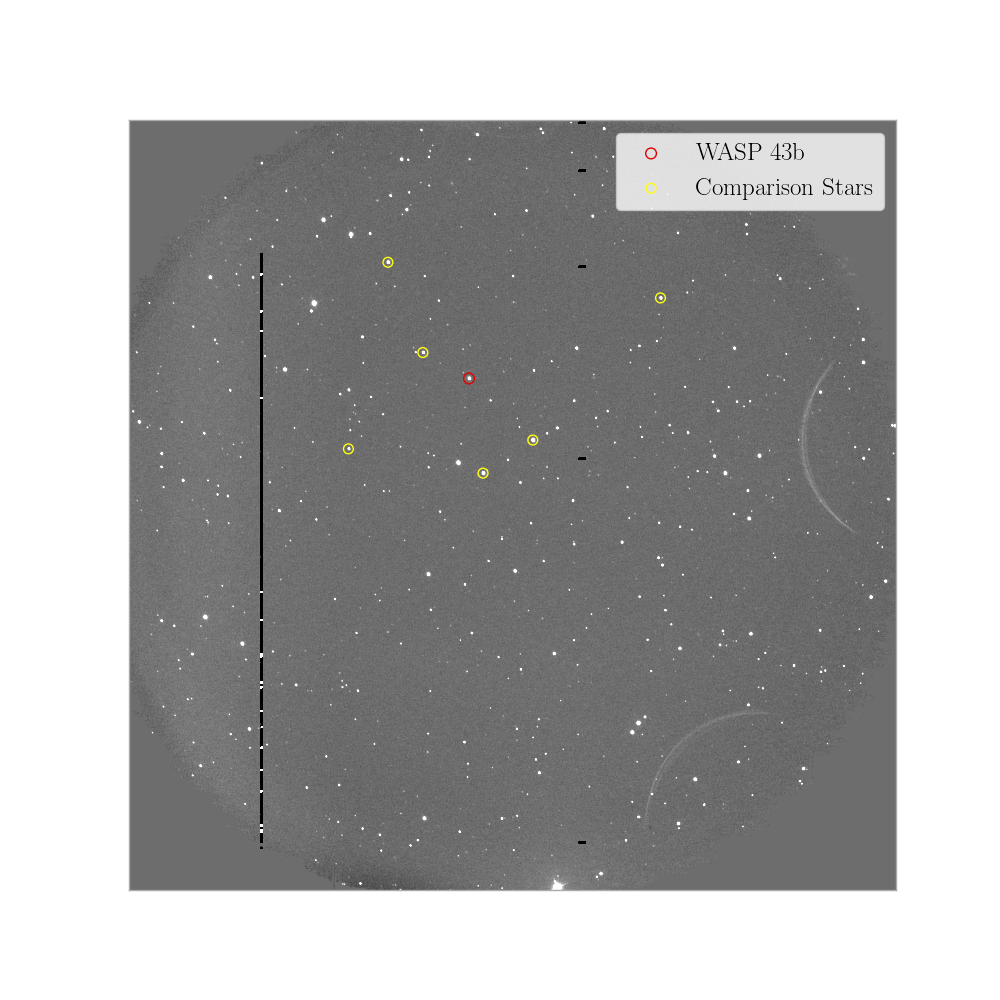

In [17]:
image = hdul[0].data
plt.rcParams.update({"text.usetex":True,"font.family": "serif"})
z = ZScaleInterval()
z1,z2 = z.get_limits(image)
plt.figure(figsize = (10,10))
plt.imshow(image, vmin=z1, vmax=z2,cmap="gray")
plt.scatter(xw,yw,facecolors='none', edgecolors='xkcd:red',s = 60, label = "WASP 43b")
plt.scatter(x,y,facecolors='none', edgecolors='xkcd:yellow',s = 50, label = "Comparison Stars")
plt.xticks([]) 
plt.yticks([]) 
plt.legend(fontsize = 18)
plt.savefig("image.png")
plt.show()

In [41]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(image, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
bgsub = image - bkg.background

In [42]:
pos = [(x[i],y[i]) for i in range(len(x))]

In [43]:
positions = [(xw,yw)] + pos
aperture = CircularAperture(positions, r=12)
phot_table = aperture_photometry(bgsub, aperture)

In [44]:
print(phot_table)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 1792.0080114599812 1351.8822655368067  61940.60150650331
  2  2132.921017381356 1679.8859920970021  155024.9687702984
  3 1867.7345730507438  1856.555912841063  104159.3715233182
  4 1358.8453099308801  732.5603890614034   71930.6518663802
  5 2813.1122128932807   921.065441515269  42923.24669846853
  6 1545.8159589833672 1213.7395247001066  36196.55540529617
  7 1149.1965823319526  1728.045717381823 21991.402027814394


In [65]:
phot_tables = []
time = []
for path in paths:
    hdul = fits.open(path)
    image = hdul[0].data
    wasp_coord = SkyCoord("10h19m37.96s -9d48m23.20s", frame=FK5, obstime=hdul[0].header['DATE-OBS'])
    time.append(hdul[0].header['JD'])
    wcs = WCS(hdul[0].header)
    xw, yw = wcs.world_to_pixel(wasp_coord)
    comp = SkyCoord(ra = comp_ra, dec = comp_dec, frame=FK5, obstime=hdul[0].header['DATE-OBS'])
    x, y = wcs.world_to_pixel(comp)
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    bgsub = image - bkg.background
    pos = [(x[i],y[i]) for i in range(len(x))]
    positions = [(xw,yw)] + pos
    aperture = CircularAperture(positions, r=6)
    phot_table = aperture_photometry(bgsub, aperture)
    phot_tables.append(phot_table)

In [66]:
phot_tables[1]

id,xcenter,ycenter,aperture_sum
,pix,pix,
int32,float64,float64,float64
1,1825.9466473190987,1386.2018697236172,222242.9040094912
2,2166.237191874724,1714.9695491393843,541539.411558398
3,1900.6239877449725,1891.186803263871,359669.9652633491
4,1393.9608190454703,765.8767613842376,255883.2054395467
5,2848.1337779776873,956.9800751680118,150417.98150912666
6,1580.002719632024,1247.559713089896,125795.2078818632
7,1182.2785812030743,1761.2368258591653,75267.61522509501


In [67]:
wasp_flux = np.array([phot_tables[i][0]['aperture_sum'] for i in range(len(paths))])
comp_flux = np.array([np.mean(phot_tables[i][1:]['aperture_sum']) for i in range(len(paths))])

In [68]:
wasp_err = np.sqrt(wasp_flux)
comp_err = np.array([np.sqrt(np.sum(phot_tables[i][1:]['aperture_sum']))/len(comp_ra) for i in range(len(paths))])

In [69]:
norm_flux = wasp_flux/comp_flux
# norm_flux = norm_flux/norm_flux[0]
norm_err = norm_flux*(wasp_err/wasp_flux + comp_err/comp_flux)
norm_flux = norm_flux + 1 - np.mean(norm_flux[:4])

In [70]:
np.mean(norm_err)

0.0035666125245184155

<IPython.core.display.Javascript object>


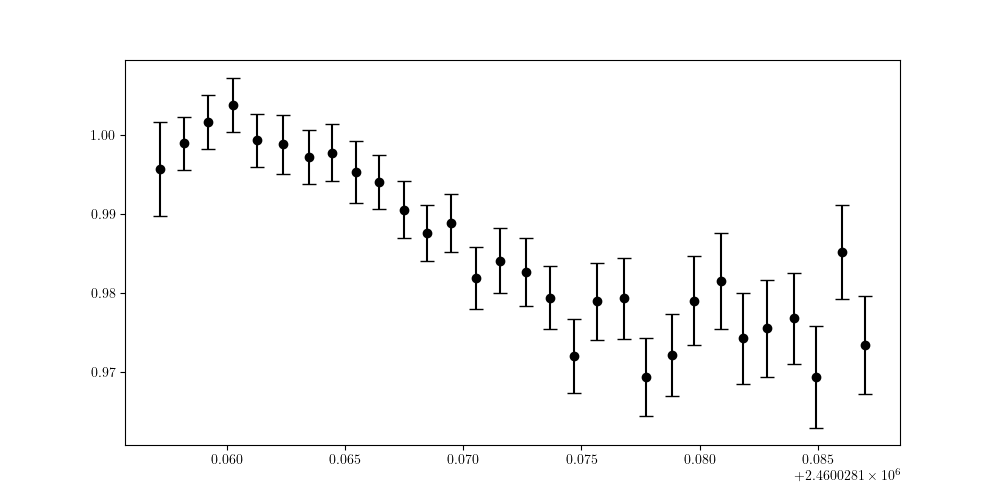

<ErrorbarContainer object of 3 artists>

In [35]:
plt.figure(figsize = (10,5))
plt.scatter(time,norm_flux,c='k')
plt.errorbar(time,norm_flux,yerr = norm_err,c='k',capsize=5,ls='none')

In [50]:
data = np.zeros((30,3))
data[:,0] = time
data[:,1] = norm_flux
data[:,2] = norm_err

In [51]:
np.save("data.npy",data)